# Background
Physiological and laboratory data provided in collaboration with MIT’s GOSSIS community initiative (e.g., blood pressure, heart rate, glucose levels, lactate levels) collected in the first 24 hours of ICU admission are critical indicators of a patient’s condition.

# Objective

To accurate predict the mortality in the 1st 24 hrs following admission to an Intensive Care Unit (ICU).

# Research Quesiton

1) To determine whether ML learning models can effectively predict ICU mortality using these early indicators and Identify which features are most influential in the prediction.
2) How does model performance compare to traditional clinical scoring systems (apache_4a_hospital_death_prob, apache_4a_icu_death_prob) for ICU mortality prediction?

# Dataset
The dataset contains records collected over the course of a year from over 91,000 intensive care unit (ICU) visits at various hospitals.
It has 91,713 records and 186 columns.

Target variable : hospital_death

### Import Necessary Libraries


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import warnings

import seaborn as sns
import matplotlib.pyplot as plt


warnings.filterwarnings('ignore')

#Use this if you are running the code on Colab
from google.colab import files
import io

uploaded = files.upload()

In [ ]:
source_df = pd.read_csv('dataset/Datathon #3 Dataset - HAD7001.csv')
print(source_df.shape)
dict_df = pd.read_csv('dataset/Datathon #3 Data Dictionary - HAD7001.csv')
dict_df.Category.value_counts()

(91713, 186)


Category
labs                         60
vitals                       52
APACHE covariate             28
demographic                  16
labs blood gas               16
APACHE comorbidity            8
identifier                    3
APACHE prediction             2
APACHE grouping               2
GOSSIS example prediction     1
Name: count, dtype: int64

In [ ]:
def plot_roc_curves(result, title):
    plt.figure(figsize=(6, 4))
    for name, metrics in result.items():
        print(name)
        if "ROC AUC" in metrics and "FPR" in metrics and "TPR" in metrics:
            fpr = np.array(metrics["FPR"])
            tpr = np.array(metrics["TPR"])
            roc_auc = metrics["ROC AUC"]
            plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], 'k--', label="Random Chance")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.show()

def print_classification_report(model_results):
    for model_name, metrics in model_results.items():
        # Extract metrics
        accuracy = metrics['Accuracy']
        precision_0 = metrics['Precision (Survived 0)']
        recall_0 = metrics['Recall (Survived 0)']
        f1_0 = metrics['F1-score (Survived 0)']
        precision_1 = metrics['Precision (Death 1)']
        recall_1 = metrics['Recall (Death 1)']
        f1_1 = metrics['F1-score (Death 1)']
        cm = metrics['Confusion Matrix']

        support_0 = cm[0][0] + cm[0][1]
        support_1 = cm[1][0] + cm[1][1]
        total_support = support_0 + support_1

        macro_precision = (precision_0 + precision_1) / 2
        macro_recall = (recall_0 + recall_1) / 2
        macro_f1 = (f1_0 + f1_1) / 2

        weighted_precision = (precision_0 * support_0 + precision_1 * support_1) / total_support
        weighted_recall = (recall_0 * support_0 + recall_1 * support_1) / total_support
        weighted_f1 = (f1_0 * support_0 + f1_1 * support_1) / total_support

        print(f"\n{model_name}")
        print("              precision    recall    f1-score    support")
        print(f"\nSurvived (0)      {precision_0:.2f}       {recall_0:.2f}       {f1_0:.2f}      {support_0}")
        print(f"   Death (1)      {precision_1:.2f}       {recall_1:.2f}       {f1_1:.2f}       {support_1}")
        print(f"\n    accuracy                           {accuracy:.2f}      {total_support}")
        print(f"   macro avg      {macro_precision:.2f}       {macro_recall:.2f}       {macro_f1:.2f}      {total_support}")
        print(f"weighted avg      {weighted_precision:.2f}       {weighted_recall:.2f}       {weighted_f1:.2f}      {total_support}")


## Select factors based on Domain knowledge

In [ ]:
demog_vars =  ['age' , 'bmi' , 'ethnicity',  'gender', 'elective_surgery', 'aids', 'cirrhosis', 'diabetes_mellitus', 'hepatic_failure', 'immunosuppression',
'leukemia', 'lymphoma', 'solid_tumor_with_metastasis', 'pre_icu_los_days', 'icu_admit_source']

# Factors Important for ICU Mortality Prediction in the First 24 Hours
vars_24 =  ['albumin_apache','arf_apache','bilirubin_apache','bun_apache','creatinine_apache',
             'fio2_apache','gcs_eyes_apache','gcs_motor_apache', 'gcs_verbal_apache','glucose_apache',  'heart_rate_apache',
               'intubated_apache','map_apache','paco2_apache','paco2_for_ph_apache','pao2_apache','ph_apache',
               'resprate_apache','sodium_apache', 'temp_apache','urineoutput_apache','wbc_apache']
### KEEP it later for benchmark
benchmark_var = ['apache_4a_hospital_death_prob']
# KeyError: "['hematrocrit_apache', 'apace_post_operative'] not in index"
#icu_vars = ['ventilated_apache, intubated_apache, apache_post_operative']
target_var = 'hospital_death'

In [ ]:
sel_variables = list(set([target_var] + demog_vars + vars_24))
print('{}  of varaibles are selected'.format(len(sel_variables)))

38  of varaibles are selected


In [ ]:
p_record_counts = source_df["patient_id"].value_counts()
p_records = p_record_counts[p_record_counts > 1]
print("Find patients with more than one record", len(p_records))

p_hospital_counts = source_df.groupby("patient_id")["hospital_id"].nunique()
patients_multiple_hospitals = p_hospital_counts[p_hospital_counts > 1]

p_encounter_counts = source_df.groupby("patient_id")["encounter_id"].nunique()
p_encounters = p_encounter_counts[p_encounter_counts > 1]

p_icu_counts = source_df.groupby("patient_id")["icu_id"].nunique()
p_icu_counters = p_icu_counts[p_icu_counts > 1]

print('Check if patient_id has stayed in more than one hospitals', len(patients_multiple_hospitals))
print("patient_id has more than one encounter", len(p_encounters))
print("patient_id has more than one icu admission", len(p_icu_counters))

Find patients with more than one record 0
Check if patient_id has stayed in more than one hospitals 0
patient_id has more than one encounter 0
patient_id has more than one icu admission 0


In [ ]:
#source_df.drop(columns=['encounter_id','patient_id','hospital_id' ,'icu_id'] , axis=1, inplace=True)
source_df.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [ ]:
df = source_df.copy()

#source_df = df.copy()

In [ ]:
source_df  = source_df[sel_variables]

### EDA for feature inspection

In [ ]:
# Drop columns with a single unique value
single_value_cols = [col for col in source_df.columns if source_df[col].nunique() == 1]
source_df.drop(columns=single_value_cols, inplace=True)
print('Drop columns with a single unique value')
print(single_value_cols )

Drop columns with a single unique value
[]


In [ ]:
# Convert columns with less than 10 unique values to categorical type
low_unique_cols = [col for col in source_df.columns if source_df[col].nunique() <= 10]
source_df[low_unique_cols] = source_df[low_unique_cols].astype('category')
print('convert them into categorical', low_unique_cols)
print(len(low_unique_cols))

convert them into categorical ['diabetes_mellitus', 'solid_tumor_with_metastasis', 'icu_admit_source', 'hospital_death', 'gcs_verbal_apache', 'aids', 'intubated_apache', 'leukemia', 'lymphoma', 'arf_apache', 'gcs_eyes_apache', 'immunosuppression', 'gender', 'cirrhosis', 'gcs_motor_apache', 'ethnicity', 'hepatic_failure', 'elective_surgery']
18


In [ ]:
numerical_vars = source_df.select_dtypes(include=["number"]).columns.tolist()
categorical_vars = source_df.select_dtypes(exclude=["number"]).columns.tolist()
dataset_overview = {
    "Total Rows": source_df.shape[0],
    "Total Columns": source_df.shape[1],
    "Duplicate Rows": source_df.duplicated().sum(),
    "Numerical Column Counts": len(numerical_vars),
    "Categorical Column counts": len(categorical_vars)
}
dataset_overview

{'Total Rows': 91713,
 'Total Columns': 38,
 'Duplicate Rows': np.int64(0),
 'Numerical Column Counts': 20,
 'Categorical Column counts': 18}

In [ ]:
description = source_df.describe()
description

,albumin_apache,sodium_apache,bun_apache,age,paco2_apache,temp_apache,pre_icu_los_days,creatinine_apache,wbc_apache,map_apache,bmi,urineoutput_apache,fio2_apache,ph_apache,heart_rate_apache,pao2_apache,glucose_apache,bilirubin_apache,resprate_apache,paco2_for_ph_apache
count,37334.000000,73113.000000,72451.00000,87485.000000,20845.000000,87605.000000,91713.000000,72860.000000,69701.000000,90719.000000,88284.000000,42715.000000,20845.000000,20845.000000,90835.000000,20845.000000,80677.000000,33579.000000,90479.000000,20845.000000
mean,2.902968,137.966373,25.82533,62.309516,42.183238,36.414472,0.835766,1.480014,12.133333,88.015873,29.185818,1738.276831,0.595751,7.353895,99.707932,131.148467,160.326822,1.147721,25.811007,42.183238
std,0.681863,5.279418,20.67298,16.775119,12.382412,0.833496,2.487756,1.525787,6.917984,42.032412,8.275142,1448.162411,0.263238,0.097755,30.870502,83.607292,90.790551,2.165538,15.106312,12.382412
min,1.200000,117.000000,4.00000,16.000000,18.000000,32.100000,-24.947222,0.300000,0.900000,40.000000,14.844926,0.000000,0.210000,6.960540,30.000000,31.000000,39.000000,0.100000,4.000000,18.000000
25%,2.400000,135.000000,13.00000,52.000000,34.400000,36.200000,0.035417,0.720000,7.500000,54.000000,23.641975,740.361600,0.400000,7.308000,86.000000,77.500000,97.000000,0.400000,11.000000,34.400000
50%,2.900000,138.000000,19.00000,65.000000,40.000000,36.500000,0.138889,0.980000,10.400000,67.000000,27.654655,1386.201600,0.500000,7.360000,104.000000,103.500000,133.000000,0.600000,28.000000,40.000000
75%,3.400000,141.000000,32.00000,75.000000,47.000000,36.700000,0.409028,1.530000,15.100000,125.000000,32.930206,2324.548800,0.850000,7.419000,120.000000,153.000000,196.000000,1.100000,36.000000,47.000000
max,4.600000,158.000000,127.00000,89.000000,95.000000,39.700000,159.090972,11.180000,45.800000,200.000000,67.814990,8716.669632,1.000000,7.590000,178.000000,498.000000,598.700000,51.000000,60.000000,95.000000


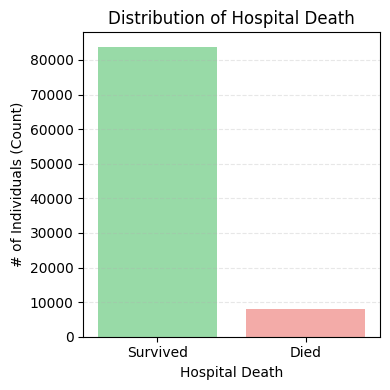

In [ ]:
c = sns.color_palette("pastel")
target_var = 'hospital_death'
value_counts = source_df[target_var].value_counts()
category_order = [0, 1]  # If 0 is for 'Died' and 1 is for 'Survived'
category_labels = ['Survived', 'Died']
category_colors = [c[2], c[3]]

plt.figure(figsize=(4, 4))
sns.barplot(x=category_order, y=value_counts[category_order].values, palette=category_colors)

plt.title("Distribution of Hospital Death")
plt.ylabel('# of Individuals (Count)')
plt.xlabel("Hospital Death")
plt.xticks(ticks=category_order, labels=category_labels)  # Set custom labels on x-axis
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


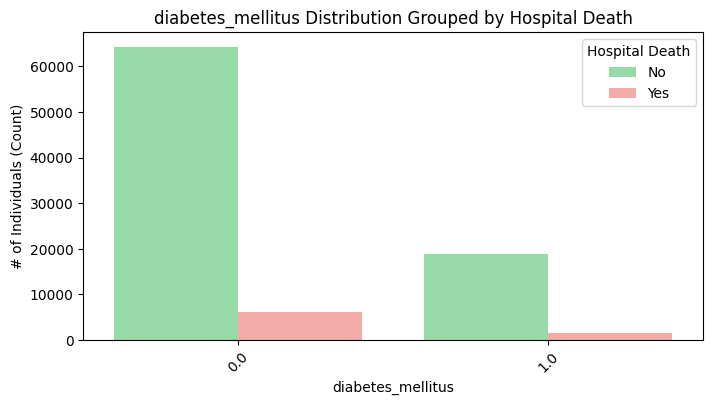

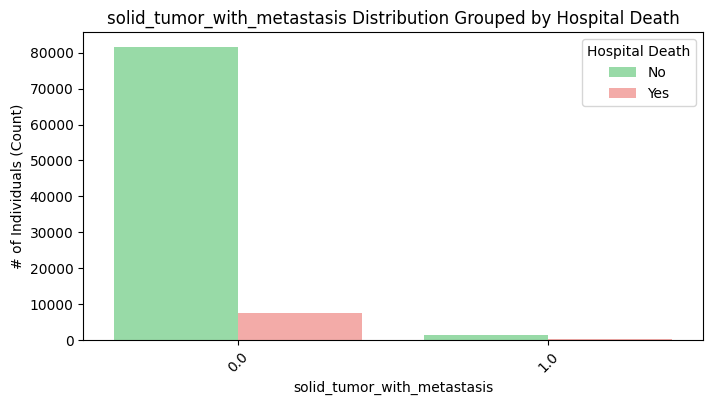

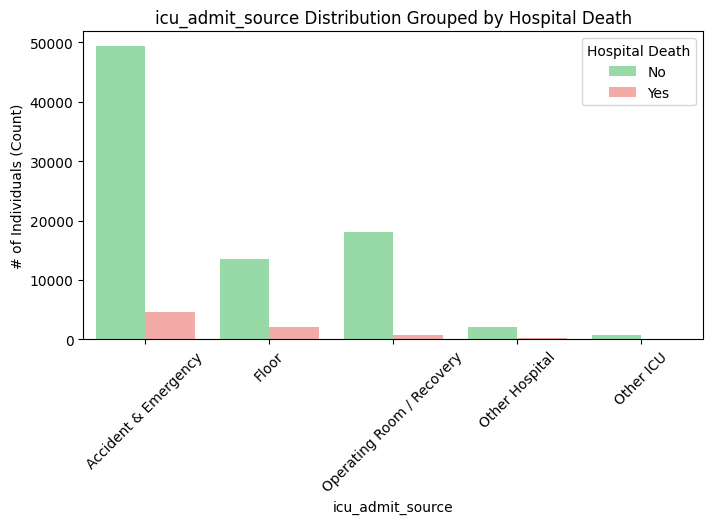

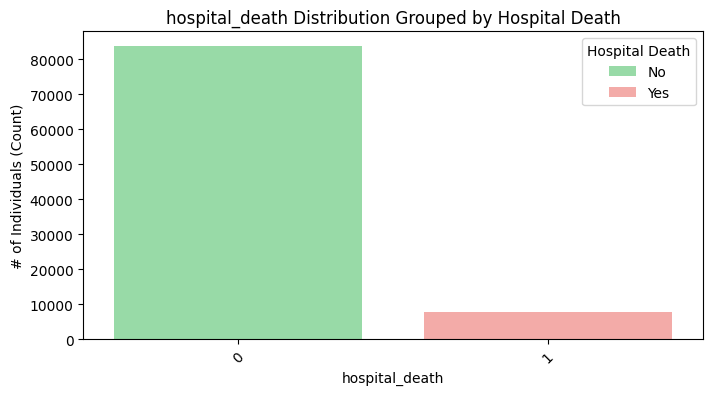

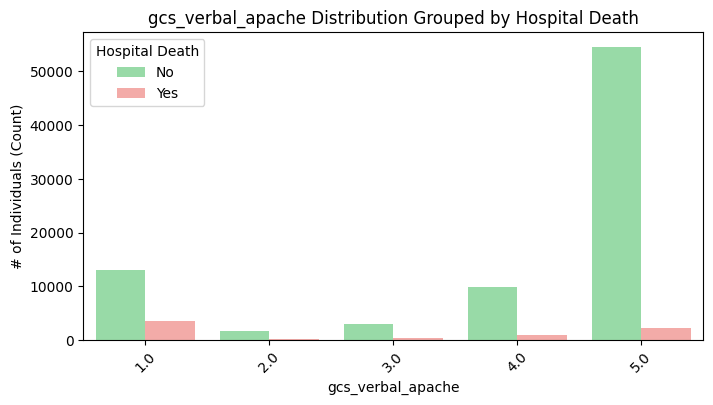

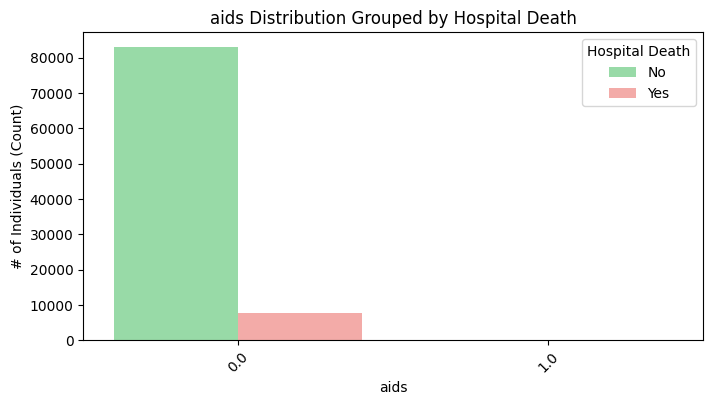

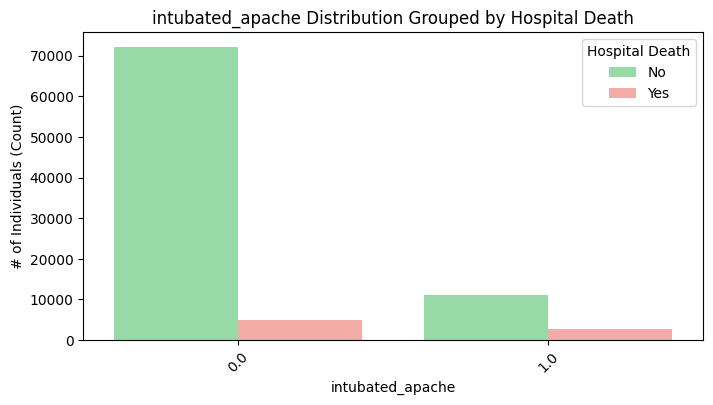

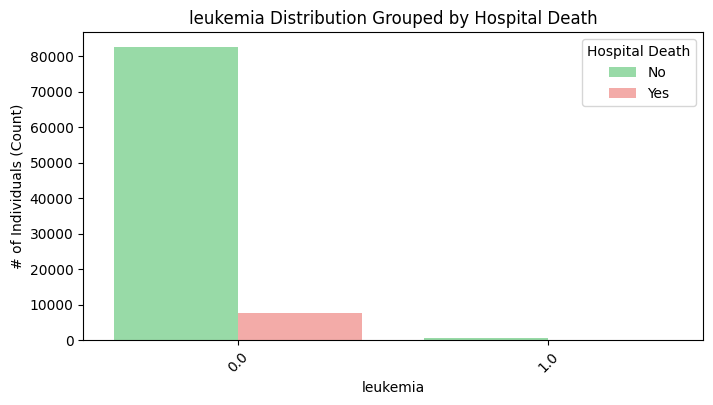

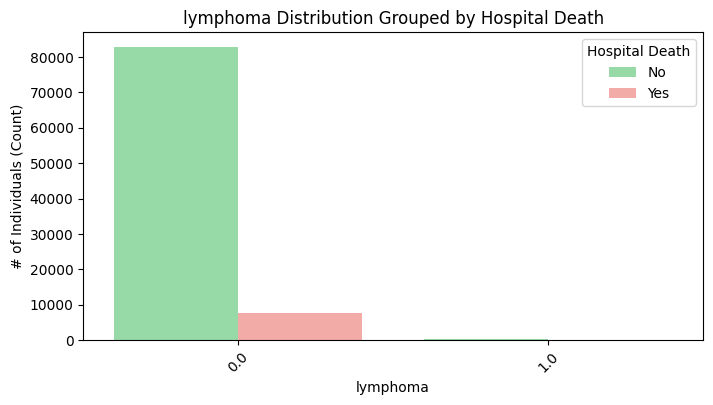

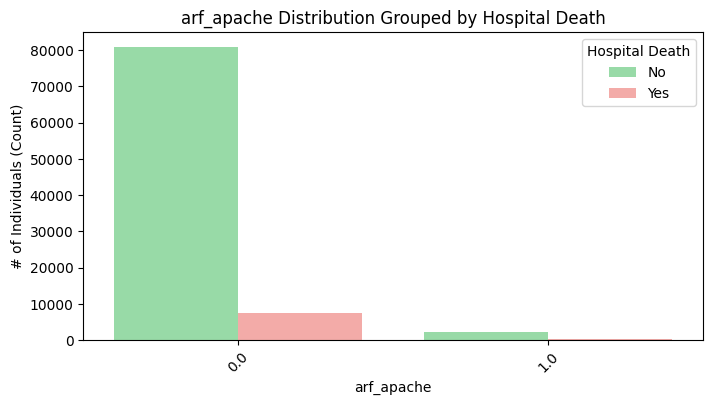

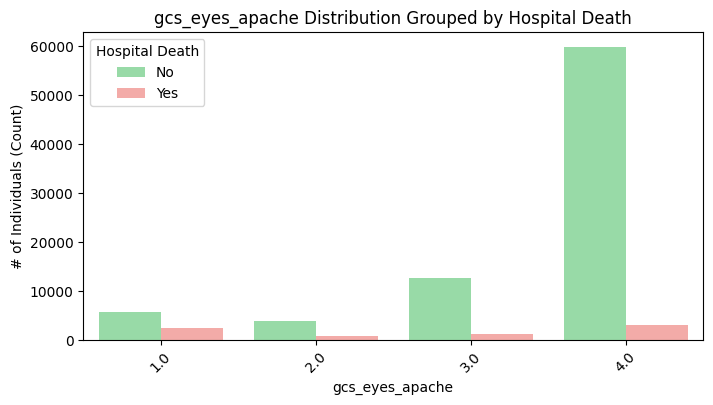

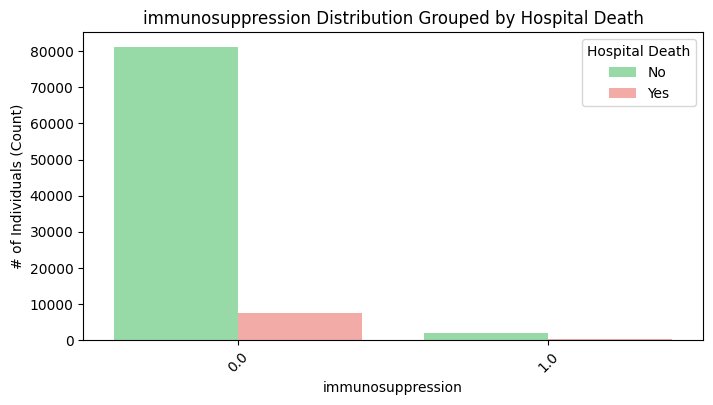

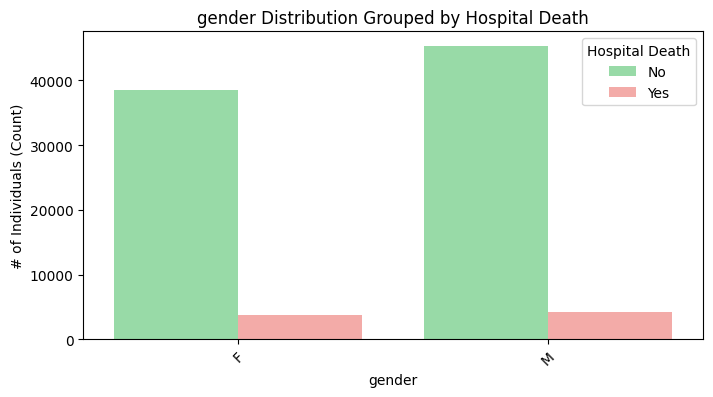

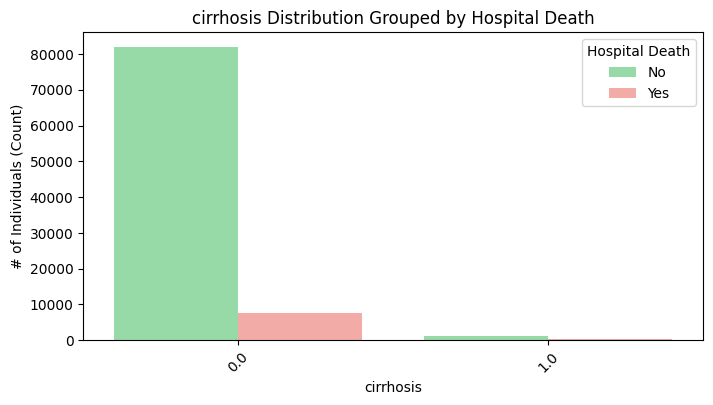

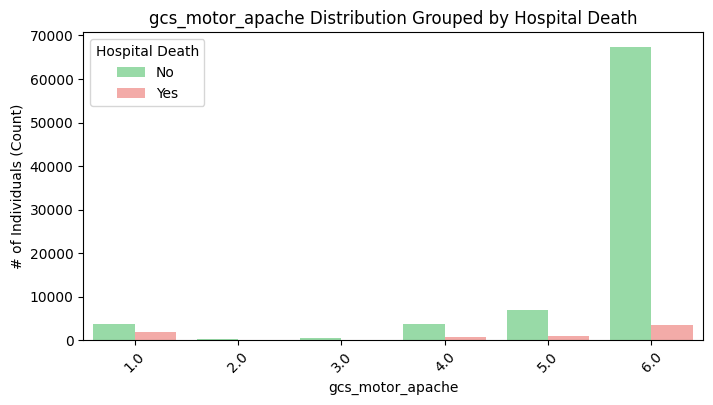

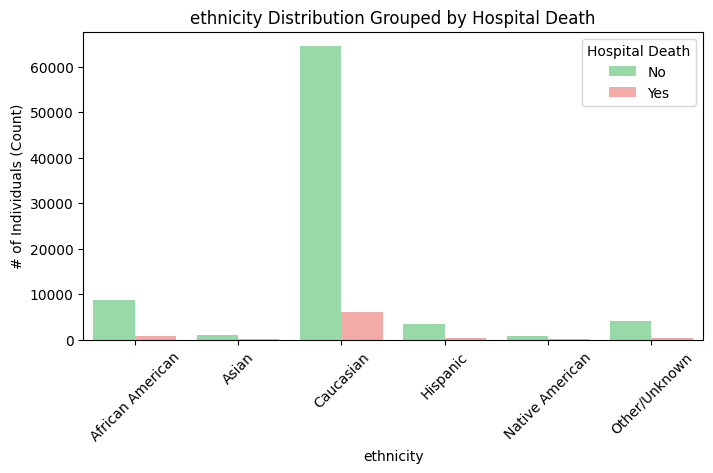

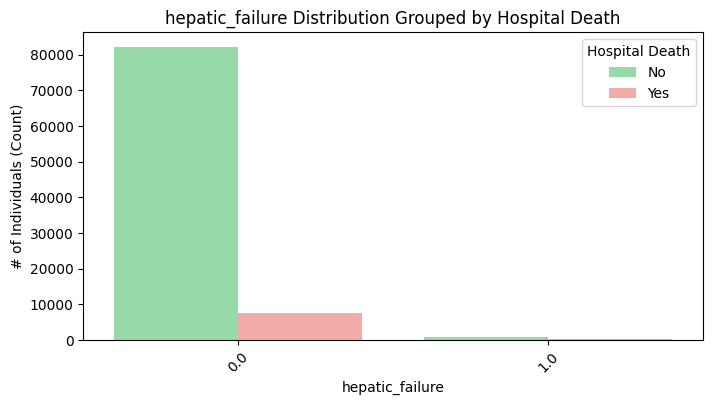

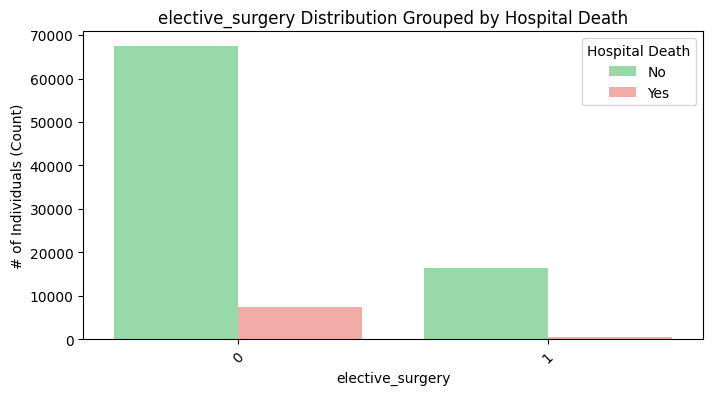

In [ ]:
for feature in categorical_vars:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=source_df, x=feature, hue=target_var, palette=category_colors)
    plt.title(f'{feature} Distribution Grouped by Hospital Death')
    plt.xlabel(feature)
    plt.ylabel('# of Individuals (Count)')
    plt.xticks(rotation=45)
    plt.legend(title='Hospital Death', labels=['No', 'Yes'])
    plt.show()

In [ ]:
categorical_vars

['diabetes_mellitus',
 'solid_tumor_with_metastasis',
 'icu_admit_source',
 'hospital_death',
 'gcs_verbal_apache',
 'aids',
 'intubated_apache',
 'leukemia',
 'lymphoma',
 'arf_apache',
 'gcs_eyes_apache',
 'immunosuppression',
 'gender',
 'cirrhosis',
 'gcs_motor_apache',
 'ethnicity',
 'hepatic_failure',
 'elective_surgery']

In [ ]:
numerical_vars

['albumin_apache',
 'sodium_apache',
 'bun_apache',
 'age',
 'paco2_apache',
 'temp_apache',
 'pre_icu_los_days',
 'creatinine_apache',
 'wbc_apache',
 'map_apache',
 'bmi',
 'urineoutput_apache',
 'fio2_apache',
 'ph_apache',
 'heart_rate_apache',
 'pao2_apache',
 'glucose_apache',
 'bilirubin_apache',
 'resprate_apache',
 'paco2_for_ph_apache']

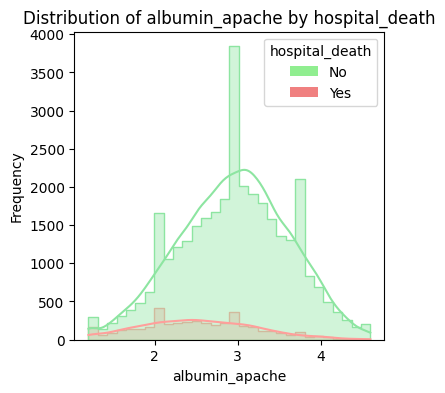

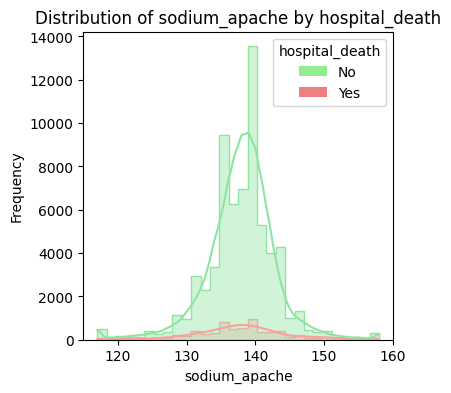

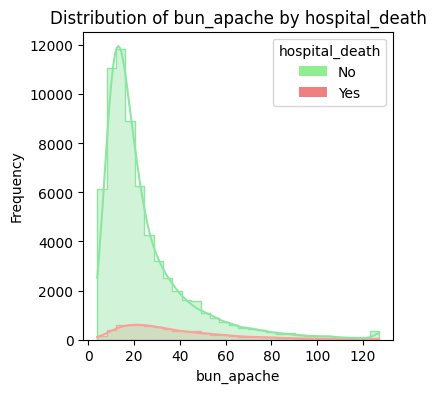

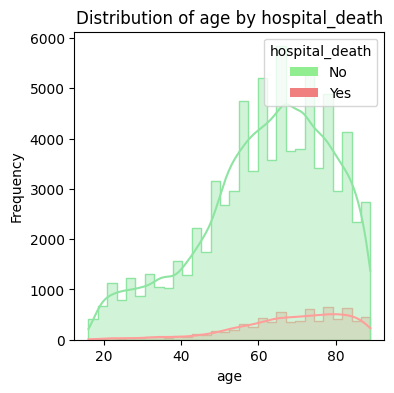

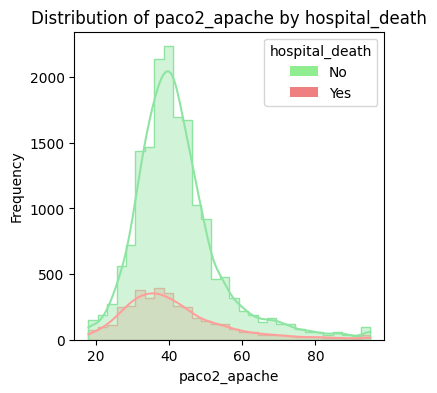

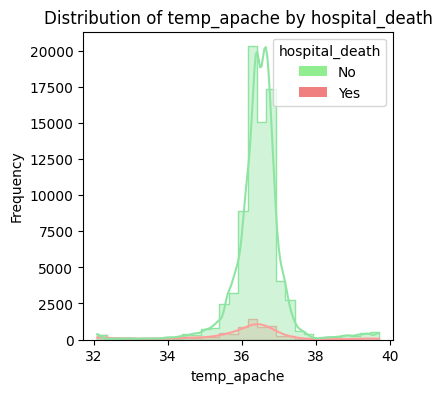

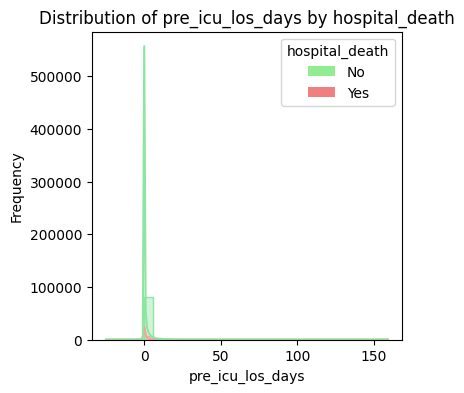

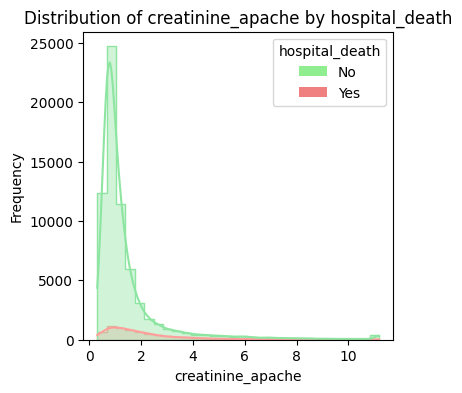

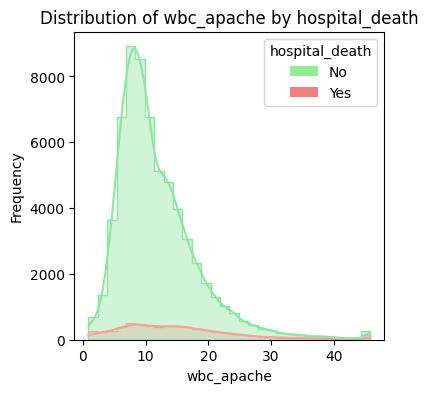

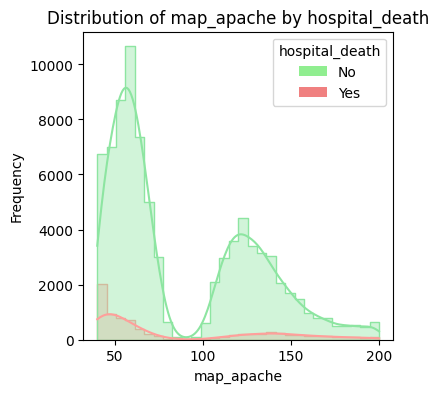

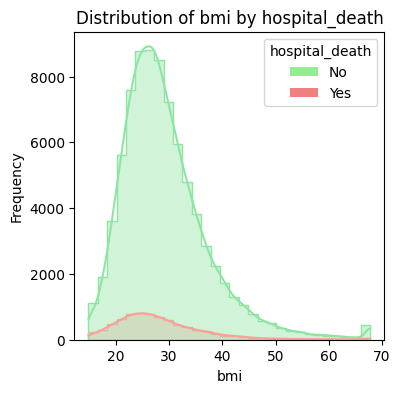

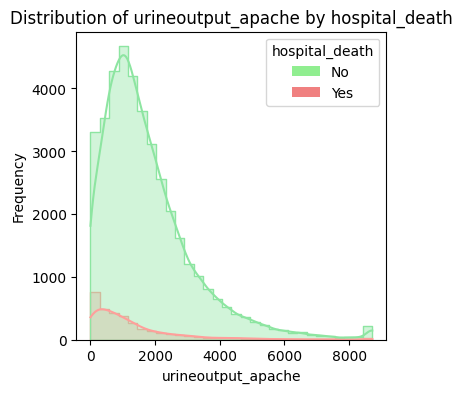

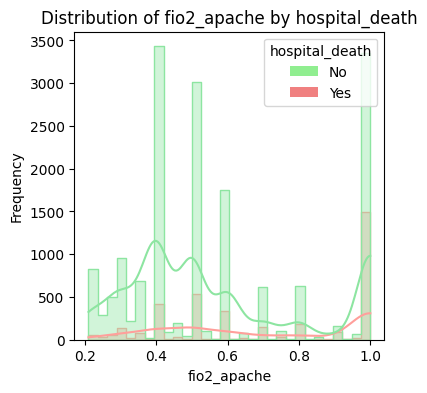

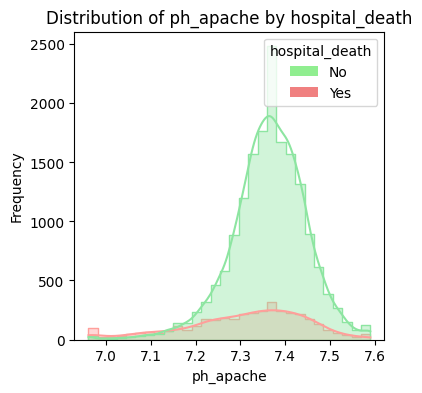

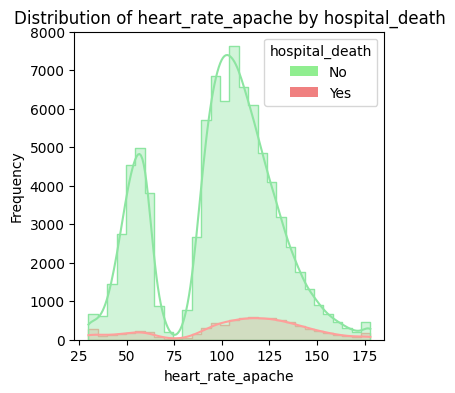

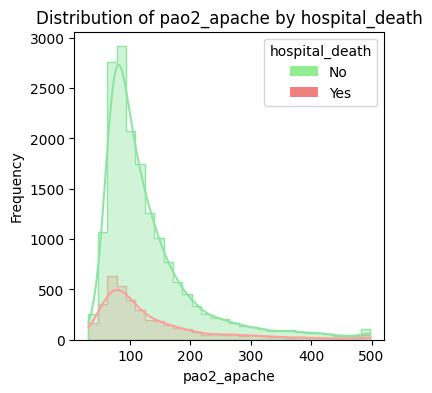

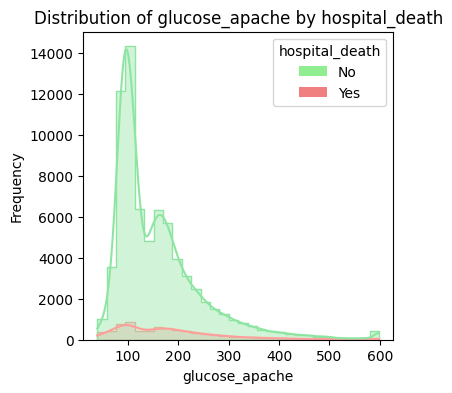

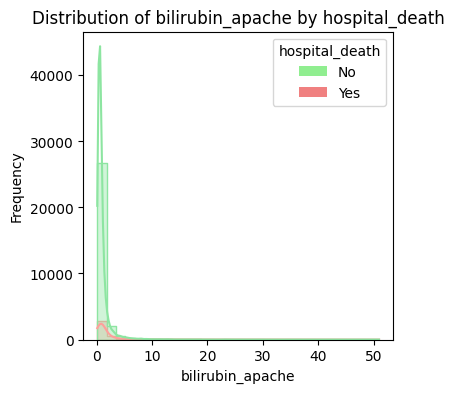

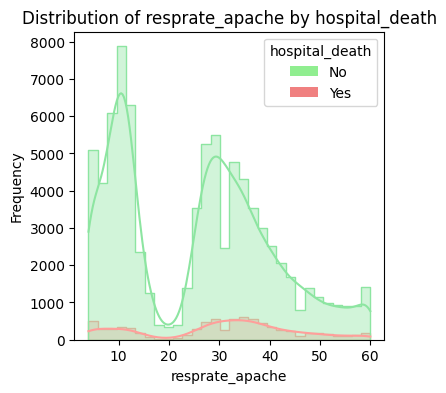

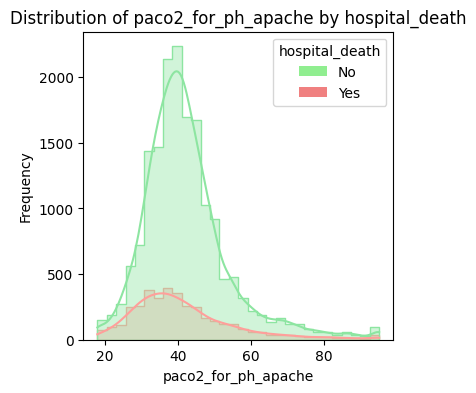

In [ ]:
from matplotlib.patches import Patch

for col in numerical_vars:
    plt.figure(figsize=(4, 4))
    sns.histplot(data=source_df, x=col, hue=target_var, kde=True, bins=30, palette=category_colors, element='step', alpha=0.4)
    plt.title(f'Distribution of {col} by hospital_death')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    legend_elements = [ Patch(facecolor='lightgreen', label='No'), Patch(facecolor='lightcoral',label='Yes') ]
    plt.legend(handles=legend_elements, title='hospital_death', loc='upper right')
    plt.show()




# Missing Values

### Instead of dropping them, to investigate the missingness pattern
1. Either impute 999 to indicate "Not measure" (Data driven approach)
2. Impute with Median group by conditions <<<=== Need to investigagte further
3. Impute with Multiple Imputation (MICE)

In [ ]:
num_missing = [col for col in numerical_vars if source_df[col].isnull().sum() > 0]
missing_num_percent = (source_df[num_missing].isnull().sum() / len(source_df))
missing_num_percent = missing_num_percent.sort_values(ascending=False)
print(missing_num_percent)

ph_apache              0.772715
pao2_apache            0.772715
paco2_apache           0.772715
paco2_for_ph_apache    0.772715
fio2_apache            0.772715
bilirubin_apache       0.633869
albumin_apache         0.592926
urineoutput_apache     0.534254
wbc_apache             0.240010
bun_apache             0.210025
creatinine_apache      0.205565
sodium_apache          0.202807
glucose_apache         0.120332
age                    0.046100
temp_apache            0.044792
bmi                    0.037388
resprate_apache        0.013455
map_apache             0.010838
heart_rate_apache      0.009573
dtype: float64


In [ ]:
cat_missing = [col for col in categorical_vars if source_df[col].isnull().sum() > 0]
missing_cat_percent = (source_df[cat_missing].isnull().sum() / len(source_df))
missing_cat_percent = missing_cat_percent.sort_values(ascending=False)
print(missing_cat_percent)

gcs_verbal_apache              0.020728
gcs_eyes_apache                0.020728
gcs_motor_apache               0.020728
ethnicity                      0.015210
leukemia                       0.007796
diabetes_mellitus              0.007796
solid_tumor_with_metastasis    0.007796
aids                           0.007796
cirrhosis                      0.007796
lymphoma                       0.007796
intubated_apache               0.007796
arf_apache                     0.007796
hepatic_failure                0.007796
immunosuppression              0.007796
icu_admit_source               0.001221
gender                         0.000273
dtype: float64


In [ ]:
missing_threshold = 0.6

cat_columns_to_drop = missing_cat_percent[missing_cat_percent > missing_threshold].index
num_columns_to_drop = missing_num_percent[missing_num_percent > missing_threshold].index

In [ ]:
num_columns_to_drop

Index(['ph_apache', 'pao2_apache', 'paco2_apache', 'paco2_for_ph_apache',
       'fio2_apache', 'bilirubin_apache'],
      dtype='object')

=> Imputation may introduce bias if data is not missing at random.

=> Some values may be missing because they weren’t measured due to clinical decisions (e.g., arterial blood gases not taken unless respiratory distress is suspected)


=>  As 'h1' for hourly assessment and 'd1' for daily assessment

=> Even if 70% is missed, retain the 'h' prefix variables

We I will treat it as "not measured" and impute '999'

In [ ]:
# missing_threshold = 0.6
num_columns_to_drop = missing_num_percent[missing_num_percent > missing_threshold]
h1_columns = num_columns_to_drop[num_columns_to_drop.index.str.startswith('h1')].index.tolist()
num_columns_to_drop = num_columns_to_drop[~num_columns_to_drop.index.str.startswith('h1')].index.tolist()
print("Columns to drop:", num_columns_to_drop)
print("Columns to impute:", h1_columns)

Columns to drop: ['ph_apache', 'pao2_apache', 'paco2_apache', 'paco2_for_ph_apache', 'fio2_apache', 'bilirubin_apache']
Columns to impute: []


In [ ]:
print("Before Dropping Category Missing Values ", source_df.shape[1])
source_df.drop(columns=cat_columns_to_drop, inplace=True)
print("AFter Dropping Category Missing Values",source_df.shape[1])

print("Before Dropping Numerical Missing Values", source_df.shape[1])
source_df.drop(columns=num_columns_to_drop, inplace=True)
print("Imputed columns")
source_df[h1_columns] = source_df[h1_columns].fillna(999)
print("AFter Dropping Numerical Missing Values", source_df.shape[1])

Before Dropping Category Missing Values  38
AFter Dropping Category Missing Values 38
Before Dropping Numerical Missing Values 38
Imputed columns
AFter Dropping Numerical Missing Values 32


###  Impute the rest of the missing values

In [ ]:
numerical_vars = source_df.select_dtypes(include=["number"]).columns.tolist()

num_missing_after = [col for col in numerical_vars if source_df[col].isnull().sum() > 0]
d1_h1_columns = [col for col in num_missing_after if col.startswith(('d1_', 'h1_'))]
demo_cols = [col for col in num_missing_after if col not in d1_h1_columns]
print("Columns starting with 'd1_' or 'h1_':", d1_h1_columns)
print("The rest of the variables ':", demo_cols)

# Impute  continuous numerical variables with median values
source_df[d1_h1_columns] = source_df[d1_h1_columns].fillna(999)
for col in demo_cols:
    source_df[col].fillna(source_df[col].median(), inplace=True)

Columns starting with 'd1_' or 'h1_': []
The rest of the variables ': ['albumin_apache', 'sodium_apache', 'bun_apache', 'age', 'temp_apache', 'creatinine_apache', 'wbc_apache', 'map_apache', 'bmi', 'urineoutput_apache', 'heart_rate_apache', 'glucose_apache', 'resprate_apache']


In [ ]:
num_missing = [col for col in numerical_vars if source_df[col].isnull().sum() > 0]
print(num_missing)

[]


In [ ]:
print(source_df.shape, df.shape)
source_df['benchmark']  = df[benchmark_var]
print(source_df.shape, df.shape)

(91713, 32) (91713, 186)
(91713, 33) (91713, 186)


### Drop features has correlation score > 70

In [ ]:
eliminate_correlation = True
if eliminate_correlation:
    correlation_threshold = 0.7
    numerical_df = source_df[numerical_vars]
    corr_matrix = numerical_df.corr()
    high_corr_mask = (np.abs(corr_matrix) > correlation_threshold ) & ~np.eye(corr_matrix.shape[0], dtype=bool)
    features_to_drop = set()

    while high_corr_mask.values.any():
        counts = high_corr_mask.sum(axis=0)
        feature_to_drop = counts.idxmax()
        features_to_drop.add(feature_to_drop)
        high_corr_mask.loc[feature_to_drop, :] = False
        high_corr_mask.loc[:, feature_to_drop] = False
    print(features_to_drop)
    #source_df.drop(columns=list(features_to_drop), inplace=True)

set()


In [ ]:
source_df.shape

(91713, 33)

### Handle missing values in Categorical_vars

In [ ]:
missing_cat_percent

gcs_verbal_apache              0.020728
gcs_eyes_apache                0.020728
gcs_motor_apache               0.020728
ethnicity                      0.015210
leukemia                       0.007796
diabetes_mellitus              0.007796
solid_tumor_with_metastasis    0.007796
aids                           0.007796
cirrhosis                      0.007796
lymphoma                       0.007796
intubated_apache               0.007796
arf_apache                     0.007796
hepatic_failure                0.007796
immunosuppression              0.007796
icu_admit_source               0.001221
gender                         0.000273
dtype: float64

In [ ]:
cat_missing

['diabetes_mellitus',
 'solid_tumor_with_metastasis',
 'icu_admit_source',
 'gcs_verbal_apache',
 'aids',
 'intubated_apache',
 'leukemia',
 'lymphoma',
 'arf_apache',
 'gcs_eyes_apache',
 'immunosuppression',
 'gender',
 'cirrhosis',
 'gcs_motor_apache',
 'ethnicity',
 'hepatic_failure']

In [ ]:
# drop it instead of imputing
print("Before dropping category", source_df.shape)
source_df.dropna(subset=[col for col in cat_missing ], inplace=True)
print("After dropping category", source_df.shape)


Before dropping category (91713, 33)
After dropping category (88340, 33)


In [ ]:
for cat in categorical_vars:
    print(source_df[cat] .value_counts())

diabetes_mellitus
0.0    68243
1.0    20097
Name: count, dtype: int64
solid_tumor_with_metastasis
0.0    86492
1.0     1848
Name: count, dtype: int64
icu_admit_source
Accident & Emergency         52320
Operating Room / Recovery    18025
Floor                        15121
Other Hospital                2289
Other ICU                      585
Name: count, dtype: int64
hospital_death
0    80870
1     7470
Name: count, dtype: int64
gcs_verbal_apache
5.0    55866
1.0    16532
4.0    10802
3.0     3228
2.0     1912
Name: count, dtype: int64
aids
0.0    88263
1.0       77
Name: count, dtype: int64
intubated_apache
0.0    75330
1.0    13010
Name: count, dtype: int64
leukemia
0.0    87705
1.0      635
Name: count, dtype: int64
lymphoma
0.0    87970
1.0      370
Name: count, dtype: int64
arf_apache
0.0    85836
1.0     2504
Name: count, dtype: int64
gcs_eyes_apache
4.0    61855
3.0    13712
1.0     8156
2.0     4617
Name: count, dtype: int64
immunosuppression
0.0    85989
1.0     2351
Name: count

In [ ]:
#sns.pairplot(source_df, hue=target_var, palette=category_colors)
#plt.show()

In [ ]:
source_df.head(2)

,diabetes_mellitus,solid_tumor_with_metastasis,icu_admit_source,albumin_apache,sodium_apache,hospital_death,bun_apache,age,gcs_verbal_apache,aids,...,gender,cirrhosis,gcs_motor_apache,heart_rate_apache,glucose_apache,ethnicity,resprate_apache,hepatic_failure,elective_surgery,benchmark
0,1.0,0.0,Floor,2.3,134.0,0,31.0,68.0,4.0,0.0,...,M,0.0,6.0,118.0,168.0,Caucasian,36.0,0.0,0,0.10
1,1.0,0.0,Floor,2.9,145.0,0,9.0,77.0,1.0,0.0,...,F,0.0,3.0,120.0,145.0,Caucasian,33.0,0.0,0,0.47


In [ ]:
source_df.to_csv('clean_df.csv', header=False)

# Data Preprocessing : Inspect the levels of categorical variables


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

def preprocess_data(source_df, binary_cols, dummy_columns):
    benchmark_df = source_df.pop('benchmark')
    t_df = source_df.copy()

    categorical_missing_cols = [col for col in dummy_columns if col in t_df.columns and t_df[col].isnull().sum() > 0]
    t_df.dropna(subset=categorical_missing_cols, inplace=True)

    h1_d1_cols = [col for col in t_df.columns if col.startswith('h1') or col.startswith('d1')]
    continuous_columns = [col for col in t_df.select_dtypes(include=["number"]).columns
                          if col not in h1_d1_cols + ["hospital_death"]]
    t_df[h1_d1_cols] = t_df[h1_d1_cols].fillna(999)

    for col in continuous_columns:
        t_df[col].fillna(t_df[col].median(), inplace=True)
    if "gender" in t_df.columns:
        t_df["gender"] = t_df["gender"].map({"M": 1, "F": 0}).astype("category")

    for col in binary_cols:
        if col in t_df.columns:
            t_df[col] = t_df[col].astype("category")

    t_df = pd.get_dummies(t_df, columns=dummy_columns, drop_first=True, dtype=bool)
    boolean_columns = t_df.select_dtypes(include=['bool']).columns
    t_df[boolean_columns] = t_df[boolean_columns].astype(int)

    t_df["hospital_death"] = t_df["hospital_death"].astype(int)

    return t_df, benchmark_df

In [ ]:
categorical_vars

['diabetes_mellitus',
 'solid_tumor_with_metastasis',
 'icu_admit_source',
 'hospital_death',
 'gcs_verbal_apache',
 'aids',
 'intubated_apache',
 'leukemia',
 'lymphoma',
 'arf_apache',
 'gcs_eyes_apache',
 'immunosuppression',
 'gender',
 'cirrhosis',
 'gcs_motor_apache',
 'ethnicity',
 'hepatic_failure',
 'elective_surgery']

In [ ]:
source_df.hepatic_failure.value_counts()

hepatic_failure
0.0    87179
1.0     1161
Name: count, dtype: int64

In [ ]:
binary_cols = ['elective_surgery', 'aids', 'cirrhosis', 'diabetes_mellitus',
               'hepatic_failure', 'immunosuppression', 'leukemia',
               'lymphoma', 'gender', 'intubated_apache', 'arf_apache',
               'solid_tumor_with_metastasis']


dummy_columns = ['ethnicity', 'gcs_verbal_apache', 'icu_admit_source', 'gcs_motor_apache', 'gcs_eyes_apache']

processed_df, benchmark_df = preprocess_data(source_df.copy(), binary_cols, dummy_columns)
print(processed_df.shape)

(88340, 48)


In [ ]:
benchmark_df

0        0.10
1        0.47
2        0.00
3        0.04
5        0.05
         ... 
91708    0.12
91709    0.03
91710    0.05
91711    0.07
91712    0.19
Name: benchmark, Length: 88340, dtype: float64

In [ ]:
for i in range(0, len(processed_df.columns), 20):
    display(processed_df.iloc[:, i:i+20].head(1))

,diabetes_mellitus,solid_tumor_with_metastasis,albumin_apache,sodium_apache,hospital_death,bun_apache,age,aids,temp_apache,pre_icu_los_days,intubated_apache,leukemia,creatinine_apache,wbc_apache,lymphoma,arf_apache,map_apache,bmi,urineoutput_apache,immunosuppression
0,1.0,0.0,2.3,134.0,0,31.0,68.0,0.0,39.3,0.541667,0.0,0.0,2.51,14.1,0.0,0.0,40.0,22.73,1386.2016,0.0


,gender,cirrhosis,heart_rate_apache,glucose_apache,resprate_apache,hepatic_failure,elective_surgery,ethnicity_Asian,ethnicity_Caucasian,ethnicity_Hispanic,ethnicity_Native American,ethnicity_Other/Unknown,gcs_verbal_apache_2.0,gcs_verbal_apache_3.0,gcs_verbal_apache_4.0,gcs_verbal_apache_5.0,icu_admit_source_Floor,icu_admit_source_Operating Room / Recovery,icu_admit_source_Other Hospital,icu_admit_source_Other ICU
0,1,0.0,118.0,168.0,36.0,0.0,0,0,1,0,0,0,0,0,1,0,1,0,0,0


,gcs_motor_apache_2.0,gcs_motor_apache_3.0,gcs_motor_apache_4.0,gcs_motor_apache_5.0,gcs_motor_apache_6.0,gcs_eyes_apache_2.0,gcs_eyes_apache_3.0,gcs_eyes_apache_4.0
0,0,0,0,0,1,0,1,0


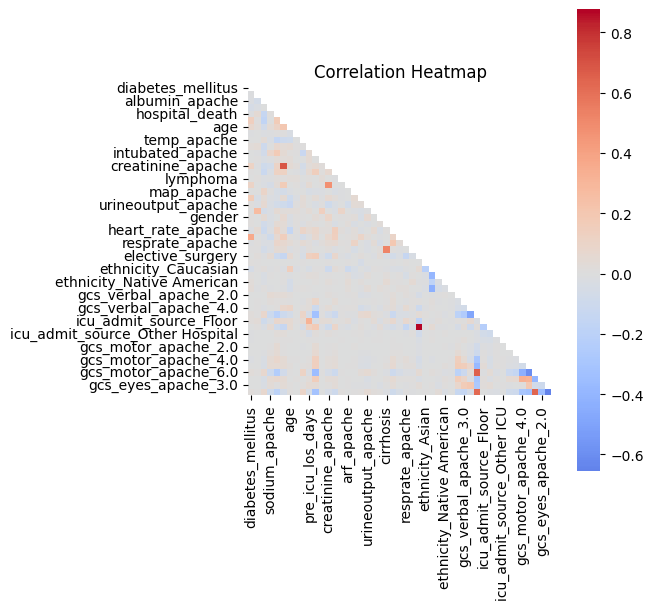

In [ ]:
corr_mtx = processed_df.corr()
mask = np.triu(np.ones_like(corr_mtx, dtype=bool))
plt.figure(figsize=(5, 6))
sns.heatmap(corr_mtx, cmap="coolwarm", mask=mask,center=0, square=True, annot=False)
plt.title("Correlation Heatmap ")
plt.show()

# Model Building

# # RQ 1:

To determine whether deep learning models can effectively predict ICU mortality using these early indicators and Identify which features are most influential in the prediction.

In [ ]:
benchmark_df

0        0.10
1        0.47
2        0.00
3        0.04
5        0.05
         ... 
91708    0.12
91709    0.03
91710    0.05
91711    0.07
91712    0.19
Name: benchmark, Length: 88340, dtype: float64

In [ ]:
processed_df, benchmark_df = preprocess_data(source_df.copy() , binary_cols, dummy_columns)

classes = processed_df['hospital_death'].unique()
y = processed_df.pop('hospital_death')
X = processed_df.copy()
X['benchmark'] = benchmark_df
display(X.sample(2))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
train_benchmark = X_train.pop('benchmark')
test_benchmark = X_test.pop('benchmark')
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("y_train value_counts", y_train.value_counts())
print("y_test value_counts", y_test.value_counts())
X_train.shape, X_test.shape, y_train.shape, y_test.shape

,diabetes_mellitus,solid_tumor_with_metastasis,albumin_apache,sodium_apache,bun_apache,age,aids,temp_apache,pre_icu_los_days,intubated_apache,...,icu_admit_source_Other ICU,gcs_motor_apache_2.0,gcs_motor_apache_3.0,gcs_motor_apache_4.0,gcs_motor_apache_5.0,gcs_motor_apache_6.0,gcs_eyes_apache_2.0,gcs_eyes_apache_3.0,gcs_eyes_apache_4.0,benchmark
87237,0.0,0.0,2.9,139.0,15.0,58.0,0.0,36.4,0.221528,0.0,...,0,0,0,0,0,1,0,0,1,0.04
2847,1.0,0.0,2.9,138.0,19.0,38.0,0.0,36.1,10.397222,0.0,...,0,0,0,0,0,1,0,0,1,0.01


y_train value_counts hospital_death
0    64696
1     5976
Name: count, dtype: int64
y_test value_counts hospital_death
0    16174
1     1494
Name: count, dtype: int64


((70672, 47), (17668, 47), (70672,), (17668,))

## LogisticRegression

In [ ]:
lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train, y_train)
lr_y_pred = lr.predict(X_test)

print(confusion_matrix(y_test, lr_y_pred, labels=classes ) )
print(classification_report(y_test, lr_y_pred, labels=classes ))

[[12628  3546]
 [  385  1109]]
              precision    recall  f1-score   support

           0       0.97      0.78      0.87     16174
           1       0.24      0.74      0.36      1494

    accuracy                           0.78     17668
   macro avg       0.60      0.76      0.61     17668
weighted avg       0.91      0.78      0.82     17668



# Oversampling with SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Print class distributions
print("y_train value_counts", y_train_resampled.value_counts())
print("y_test value_counts", y_test.value_counts())

lr = LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced')
lr.fit(X_train_scaled, y_train_resampled)
lr_y_pred = lr.predict(X_test_scaled)

print(confusion_matrix(y_test, lr_y_pred, labels=classes ) )
print(classification_report(y_test, lr_y_pred, labels=classes ))

y_train value_counts hospital_death
0    64696
1    64696
Name: count, dtype: int64
y_test value_counts hospital_death
0    16174
1     1494
Name: count, dtype: int64
[[12527  3647]
 [  371  1123]]
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     16174
           1       0.24      0.75      0.36      1494

    accuracy                           0.77     17668
   macro avg       0.60      0.76      0.61     17668
weighted avg       0.91      0.77      0.82     17668



## Fine-tunning Paramerters - LogisticRegression

from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
}

log_reg = LogisticRegression(max_iter=100, random_state=42, class_weight='balanced')

grid_search = GridSearchCV( estimator=log_reg,param_grid=params, scoring='f1', cv=5, verbose=1, n_jobs=-1 )
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_
print(best_params, best_score)

y_pred = grid_search.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred, labels=classes ))
print(confusion_matrix(y_test, y_pred, labels=classes ) )

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

oversampled = True

binary_cols = ['elective_surgery', 'aids', 'cirrhosis', 'diabetes_mellitus',
               'hepatic_failure', 'immunosuppression', 'leukemia',
               'lymphoma', 'gender', 'intubated_apache', 'arf_apache',
               'solid_tumor_with_metastasis']


dummy_columns = ['ethnicity', 'gcs_verbal_apache', 'icu_admit_source', 'gcs_motor_apache', 'gcs_eyes_apache']



processed_df, benchmark_df = preprocess_data(source_df.copy() , binary_cols, dummy_columns)

classes = processed_df['hospital_death'].unique()
y = processed_df.pop('hospital_death')
X = processed_df.copy()
X['benchmark'] = benchmark_df
display(X.sample(2))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_benchmark = X_train.pop('benchmark')
test_benchmark = X_test.pop('benchmark')

print("y_train value_counts", y_train.value_counts())
print("y_test value_counts", y_test.value_counts())
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

print("NaN values before SMOTE:", X_train.isnull().sum().sum())  # Check total NaNs

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
unique_counts = (X_train_resampled.nunique() == 1).sum()
if unique_counts > 0:
    print(f"Warning: {unique_counts} columns have only one unique value. Dropping them.")
    X_train_resampled = X_train_resampled.loc[:, X_train_resampled.nunique() > 1]


scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = np.nan_to_num(X_train_scaled)  # Replace NaNs with 0
X_test_scaled = np.nan_to_num(X_test_scaled)  # Replace NaNs with 0
print("y_train value_counts", y_train_resampled.value_counts())
print("y_test value_counts", y_test.value_counts())


scaler1 = StandardScaler()
X_train_scaled1 = scaler1.fit_transform(X_train)
X_test_scaled1 = scaler1.transform(X_test)

X_train_scaled1 = np.nan_to_num(X_train_scaled1)  # Replace NaNs with 0
X_test_scaled1 = np.nan_to_num(X_test_scaled1)  # Replace NaNs with 0


if np.isnan(X_train_scaled).any() or np.isinf(X_train_scaled).any():
    print(" NaN or Inf still exists!")
else:
    print("No NaN or Inf values found")


,diabetes_mellitus,solid_tumor_with_metastasis,albumin_apache,sodium_apache,bun_apache,age,aids,temp_apache,pre_icu_los_days,intubated_apache,...,icu_admit_source_Other ICU,gcs_motor_apache_2.0,gcs_motor_apache_3.0,gcs_motor_apache_4.0,gcs_motor_apache_5.0,gcs_motor_apache_6.0,gcs_eyes_apache_2.0,gcs_eyes_apache_3.0,gcs_eyes_apache_4.0,benchmark
17708,0.0,0.0,3.6,143.0,22.0,67.0,0.0,36.5,0.036111,0.0,...,0,0,0,0,0,1,0,0,1,0.05
50992,0.0,0.0,2.9,141.0,18.0,89.0,0.0,36.5,4.579861,0.0,...,0,0,0,0,0,1,0,0,1,0.09


y_train value_counts hospital_death
0    64696
1     5976
Name: count, dtype: int64
y_test value_counts hospital_death
0    16174
1     1494
Name: count, dtype: int64
(70672, 47) (17668, 47) (70672,) (17668,)
NaN values before SMOTE: 0
y_train value_counts hospital_death
0    64696
1    64696
Name: count, dtype: int64
y_test value_counts hospital_death
0    16174
1     1494
Name: count, dtype: int64
No NaN or Inf values found


In [ ]:
print(test_benchmark.shape, X_test_scaled1.shape)

(17668,) (17668, 47)


In [ ]:
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, roc_auc_score
)
# Calculate scale_pos_weight for imbalance
#num_neg = (y_train == 0).sum()  # Survived
#num_pos = (y_train == 1).sum()  # Death
#scale_pos_weight = num_neg / num_pos
#print(f"scale_pos_weight: {scale_pos_weight:.2f}")


models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42),
    "XGBoost": XGBClassifier( objective='binary:logistic', use_label_encoder=False, eval_metric='logloss', random_state=42),
    "Naive Bayes": GaussianNB()
}

results, results1 = {}, {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train_resampled)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Get positive class probabilities

    # Compute metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    # Store results
    results[name] = {
        "Accuracy": acc,
        "Precision (Survived 0)": report["0"]["precision"],
        "Recall (Survived 0)": report["0"]["recall"],
        "F1-score (Survived 0)": report["0"]["f1-score"],
        "Precision (Death 1)": report["1"]["precision"],
        "Recall (Death 1)": report["1"]["recall"],
        "F1-score (Death 1)": report["1"]["f1-score"],
        "Confusion Matrix": conf_matrix.tolist(),
        "FPR": fpr.tolist(),  # Store FPR
        "TPR": tpr.tolist(),  # Store TPR
        "ROC AUC": roc_auc
    }


In [ ]:
print_classification_report(results)


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.94       0.92       0.93      16174
   Death (1)      0.32       0.41       0.36       1494

    accuracy                           0.88      17668
   macro avg      0.63       0.67       0.65      17668
weighted avg      0.89       0.88       0.88      17668

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.93       0.98       0.96      16174
   Death (1)      0.52       0.26       0.35       1494

    accuracy                           0.92      17668
   macro avg      0.73       0.62       0.65      17668
weighted avg      0.90       0.92       0.90      17668

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.94       0.97       0.96      16174
   Death (1)      0.51       0.29       0.37       1494

    accuracy                           0.92      17668
   macro avg      0.72       0.63       0.66      176

In [ ]:
for name, model in models.items():
    model.fit(X_train_scaled1, y_train)
    y_pred = model.predict(X_test_scaled1)
    y_prob = model.predict_proba(X_test_scaled1)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    conf_matrix = confusion_matrix(y_test, y_pred)


    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    results1[name] = {
        "Accuracy": acc,
        "Precision (Survived 0)": report["0"]["precision"],
        "Recall (Survived 0)": report["0"]["recall"],
        "F1-score (Survived 0)": report["0"]["f1-score"],
        "Precision (Death 1)": report["1"]["precision"],
        "Recall (Death 1)": report["1"]["recall"],
        "F1-score (Death 1)": report["1"]["f1-score"],
        "Confusion Matrix": conf_matrix.tolist(),
        "FPR": fpr.tolist(),
        "TPR": tpr.tolist(),
        "ROC AUC": roc_auc
    }


Logistic Regression
Random Forest
XGBoost
Naive Bayes


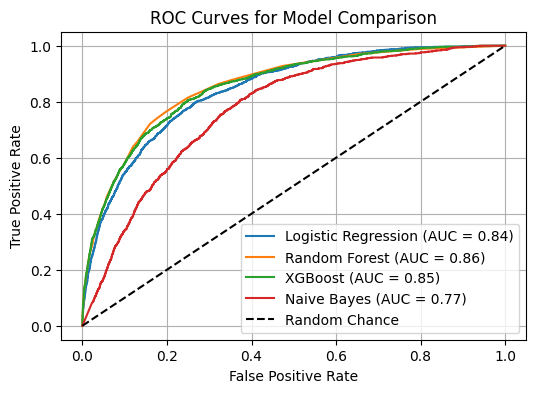

In [ ]:
plot_roc_curves(results1, 'ROC Curves for Model Comparison')

Logistic Regression
Random Forest
XGBoost
Naive Bayes


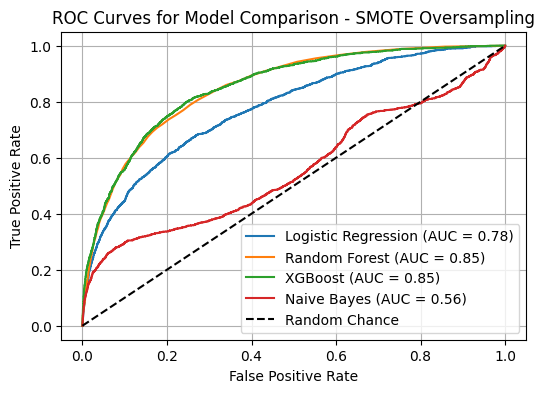

In [ ]:
plot_roc_curves(results, 'ROC Curves for Model Comparison - SMOTE Oversampling')

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from icumodel import ICUModel, ICUModel_v1, ICUModel_v2, Wide, Deep, SimpleNet

def train_deep_learning_model(dataparcel, icu_model, input_dim, epochs=10, batch_size=8, learning_rate=0.0001, oversampled=True):

    X_train_scaled, y_train_resampled, X_test_scaled, y_test = dataparcel

    X_train_scaled = np.array(X_train_scaled, dtype=np.float32)
    X_test_scaled = np.array(X_test_scaled, dtype=np.float32)
    y_train_resampled = np.array(y_train_resampled, dtype=np.float32)
    y_test = np.array(y_test, dtype=np.float32)

    # check NaN or infinite values
    X_train_scaled = np.nan_to_num(X_train_scaled)
    X_test_scaled = np.nan_to_num(X_test_scaled)

    # torch tensors
    X_train_tensor = torch.tensor(X_train_scaled)
    y_train_tensor = torch.tensor(y_train_resampled).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test_scaled)
    y_test_tensor = torch.tensor(y_test).unsqueeze(1)

    print(f"X_train_tensor shape: {X_train_tensor.shape}")
    print(f"y_train_tensor shape: {y_train_tensor.shape}")
    # datasets and dataloaders
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

    print("Init Dataset --- DONE")
    model = icu_model(input_dim)
    print("Init Model")
    print(model)
    num_params = sum(p.numel() for p in model.parameters())
    print(f"Total Parameters: {num_params}")

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
    #device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

    device = 'cpu'
    print(device)
    model.to(device)

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)

            if torch.isnan(loss).any():
                print("ERROR:: NaN loss,  stopping training")
                return results, report, model

            loss.backward()  # backpropagation
            optimizer.step()
            running_loss += loss.item() * X_batch.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Evaluation on test data
        model.eval()
        preds = []
        actuals = []
        with torch.no_grad():  # disable gradient computation for test data
            for X_batch, y_batch in test_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device).float()
                outputs = model(X_batch)
                probabilities = torch.sigmoid(outputs)
                predictions = (probabilities > 0.5).int()
                preds.extend(predictions.cpu().numpy())
                actuals.extend(y_batch.cpu().numpy())

        accuracy = accuracy_score(actuals, preds)
        report_ = classification_report(actuals, preds, output_dict=True)
        conf_matrix = confusion_matrix(actuals, preds)

        fpr, tpr, _ = roc_curve(actuals, preds)
        roc_auc = auc(fpr, tpr)


        print(f"Epoch {epoch+1}/{epochs} - Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.4f}")

    report = {str(int(float(k))) if k.replace('.', '', 1).isdigit() else k: v for k, v in report_.items()}

    model_name = icu_model.__name__
    if oversampled:
      results[model_name] = {
        "Accuracy": accuracy,
        "Precision (Survived 0)": report["0"]["precision"],
        "Recall (Survived 0)": report["0"]["recall"],
        "F1-score (Survived 0)": report["0"]["f1-score"],
        "Precision (Death 1)": report["1"]["precision"],
        "Recall (Death 1)": report["1"]["recall"],
        "F1-score (Death 1)": report["1"]["f1-score"],
        "Confusion Matrix": conf_matrix.tolist(),
        "FPR": fpr.tolist(),  # Store FPR
        "TPR": tpr.tolist(),  # Store TPR
        "ROC AUC": roc_auc
    }
      return results, report_ , model
    else:
      results1[model_name] = {
        "Accuracy": accuracy,
        "Precision (Survived 0)": report["0"]["precision"],
        "Recall (Survived 0)": report["0"]["recall"],
        "F1-score (Survived 0)": report["0"]["f1-score"],
        "Precision (Death 1)": report["1"]["precision"],
        "Recall (Death 1)": report["1"]["recall"],
        "F1-score (Death 1)": report["1"]["f1-score"],
        "Confusion Matrix": conf_matrix.tolist(),
        "FPR": fpr.tolist(),  # Store FPR
        "TPR": tpr.tolist(),  # Store TPR
        "ROC AUC": roc_auc
        }
      return results1, report_ , model


### Using Oversampling data

In [ ]:
dataparcel = (X_train_scaled, y_train_resampled, X_test_scaled, y_test)

import torch, os
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

import torch.mps
torch.mps.empty_cache()
print(torch.backends.mps.is_available())
print(torch.backends.mps.is_built())

results, ICUModel_report, _ = train_deep_learning_model(dataparcel, ICUModel, input_dim=X_train_scaled.shape[1], epochs=20, batch_size=8)
print(results["ICUModel"])  

results, ICUModel_v1_report, _ = train_deep_learning_model(dataparcel, ICUModel_v1, input_dim=X_train_scaled.shape[1], epochs=20, batch_size=8)
print(results["ICUModel_v1"])  

In [ ]:
results, ICUModel_v2_report, _ = train_deep_learning_model(dataparcel, ICUModel_v2, input_dim=X_train_scaled.shape[1], epochs=20, batch_size=8, oversampled=True)
print(results["ICUModel_v2"])

X_train_tensor shape: torch.Size([129392, 47])
y_train_tensor shape: torch.Size([129392, 1])
Init Dataset --- DONE
Init Model
ICUModel_v2(
  (model): Sequential(
    (0): Linear(in_features=47, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)
Total Parameters: 16961
cpu
Epoch 1/20 - Loss: 0.3589, Accuracy: 0.8701
Epoch 2/20 - Loss: 0.3218, Accuracy: 0.8784
Epoch 3/20 - Loss: 0.3092, Accuracy: 0.

In [ ]:
results, SimpleNet_report, _ = train_deep_learning_model(dataparcel, SimpleNet , input_dim=X_train_scaled.shape[1], epochs=20, batch_size=8, oversampled=True)
print(results["SimpleNet"])

X_train_tensor shape: torch.Size([129392, 47])
y_train_tensor shape: torch.Size([129392, 1])
Init Dataset --- DONE
Init Model
SimpleNet(
  (fc1): Linear(in_features=47, out_features=27, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=27, out_features=1, bias=True)
)
Total Parameters: 1324
cpu
Epoch 1/20 - Loss: 0.2913, Accuracy: 0.8770
Epoch 2/20 - Loss: 0.2424, Accuracy: 0.8831
Epoch 3/20 - Loss: 0.2365, Accuracy: 0.8867
Epoch 4/20 - Loss: 0.2316, Accuracy: 0.8846
Epoch 5/20 - Loss: 0.2273, Accuracy: 0.8902
Epoch 6/20 - Loss: 0.2237, Accuracy: 0.8905
Epoch 7/20 - Loss: 0.2207, Accuracy: 0.8922
Epoch 8/20 - Loss: 0.2181, Accuracy: 0.8903
Epoch 9/20 - Loss: 0.2157, Accuracy: 0.8920
Epoch 10/20 - Loss: 0.2135, Accuracy: 0.8903
Epoch 11/20 - Loss: 0.2114, Accuracy: 0.8931
Epoch 12/20 - Loss: 0.2091, Accuracy: 0.8933
Epoch 13/20 - Loss: 0.2066, Accuracy: 0.8930
Epoch 14/20 - Loss: 0.2040, Accuracy: 0.8953
Epoch 15/20 - Loss: 0.2010, Accuracy: 0.8921
Epoch 16/20 - Loss: 0.1978, Accu

In [ ]:
print_classification_report(results)


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.94       0.92       0.93      16174
   Death (1)      0.32       0.41       0.36       1494

    accuracy                           0.88      17668
   macro avg      0.63       0.67       0.65      17668
weighted avg      0.89       0.88       0.88      17668

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.93       0.98       0.96      16174
   Death (1)      0.52       0.26       0.35       1494

    accuracy                           0.92      17668
   macro avg      0.73       0.62       0.65      17668
weighted avg      0.90       0.92       0.90      17668

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.94       0.97       0.96      16174
   Death (1)      0.51       0.29       0.37       1494

    accuracy                           0.92      17668
   macro avg      0.72       0.63       0.66      176

### Data without Oversampling

results1, Deep_report, _ = train_deep_learning_model(dataparcel, Deep , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8)
print(Deep_report)

results1, report, save_model = train_deep_learning_model(dataparcel, ICUModel , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8)
print(results["ICUModel"])  

results1, report, save_model = train_deep_learning_model(dataparcel, ICUModel_v1 , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8)
print(results["ICUModel_v1"])  

In [ ]:
results1, report, save_model = train_deep_learning_model(dataparcel, ICUModel_v2 , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8, oversampled=False)
print(results["ICUModel_v2"])

X_train_tensor shape: torch.Size([129392, 47])
y_train_tensor shape: torch.Size([129392, 1])
Init Dataset --- DONE
Init Model
ICUModel_v2(
  (model): Sequential(
    (0): Linear(in_features=47, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=1, bias=True)
  )
)
Total Parameters: 16961
cpu
Epoch 1/30 - Loss: 0.3596, Accuracy: 0.9006
Epoch 2/30 - Loss: 0.3176, Accuracy: 0.8899
Epoch 3/30 - Loss: 0.3108, Accuracy: 0.

In [ ]:

results1, SimpleNet_report1, save_model1 = train_deep_learning_model(dataparcel, SimpleNet , input_dim=X_train_scaled1.shape[1], epochs=30, batch_size=8, oversampled=False)
print(results1["SimpleNet"])

X_train_tensor shape: torch.Size([129392, 47])
y_train_tensor shape: torch.Size([129392, 1])
Init Dataset --- DONE
Init Model
SimpleNet(
  (fc1): Linear(in_features=47, out_features=27, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=27, out_features=1, bias=True)
)
Total Parameters: 1324
cpu
Epoch 1/30 - Loss: 0.2899, Accuracy: 0.8806
Epoch 2/30 - Loss: 0.2409, Accuracy: 0.8846
Epoch 3/30 - Loss: 0.2339, Accuracy: 0.8877
Epoch 4/30 - Loss: 0.2284, Accuracy: 0.8878
Epoch 5/30 - Loss: 0.2235, Accuracy: 0.8903
Epoch 6/30 - Loss: 0.2187, Accuracy: 0.8886
Epoch 7/30 - Loss: 0.2131, Accuracy: 0.8929
Epoch 8/30 - Loss: 0.2071, Accuracy: 0.8952
Epoch 9/30 - Loss: 0.2011, Accuracy: 0.8999
Epoch 10/30 - Loss: 0.1959, Accuracy: 0.9001
Epoch 11/30 - Loss: 0.1918, Accuracy: 0.9010
Epoch 12/30 - Loss: 0.1884, Accuracy: 0.9025
Epoch 13/30 - Loss: 0.1857, Accuracy: 0.9020
Epoch 14/30 - Loss: 0.1833, Accuracy: 0.9004
Epoch 15/30 - Loss: 0.1814, Accuracy: 0.9033
Epoch 16/30 - Loss: 0.1796, Accu

In [ ]:
print_classification_report(results1)


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.97       0.78       0.87      16174
   Death (1)      0.24       0.74       0.36       1494

    accuracy                           0.78      17668
   macro avg      0.60       0.76       0.61      17668
weighted avg      0.91       0.78       0.82      17668

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.92       1.00       0.96      16174
   Death (1)      0.77       0.11       0.20       1494

    accuracy                           0.92      17668
   macro avg      0.84       0.56       0.58      17668
weighted avg      0.91       0.92       0.89      17668

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.93       0.98       0.96      16174
   Death (1)      0.59       0.25       0.35       1494

    accuracy                           0.92      17668
   macro avg      0.76       0.61       0.65      176

In [ ]:
print_classification_report(results)


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.94       0.92       0.93      16174
   Death (1)      0.32       0.41       0.36       1494

    accuracy                           0.88      17668
   macro avg      0.63       0.67       0.65      17668
weighted avg      0.89       0.88       0.88      17668

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.93       0.98       0.96      16174
   Death (1)      0.52       0.26       0.35       1494

    accuracy                           0.92      17668
   macro avg      0.73       0.62       0.65      17668
weighted avg      0.90       0.92       0.90      17668

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.94       0.97       0.96      16174
   Death (1)      0.51       0.29       0.37       1494

    accuracy                           0.92      17668
   macro avg      0.72       0.63       0.66      176

Logistic Regression
Random Forest
XGBoost
Naive Bayes
ICUModel_v2


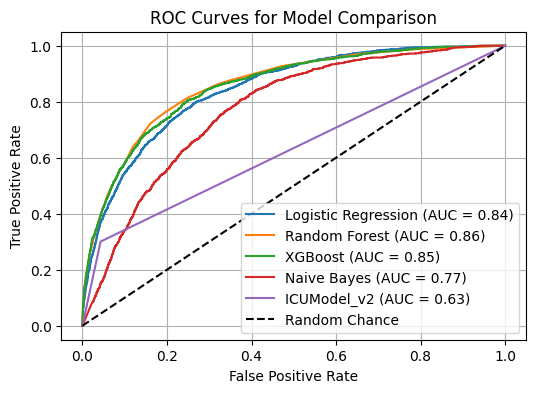

In [ ]:
plot_roc_curves(results1, 'ROC Curves for Model Comparison')

Logistic Regression
Random Forest
XGBoost
Naive Bayes
ICUModel_v2


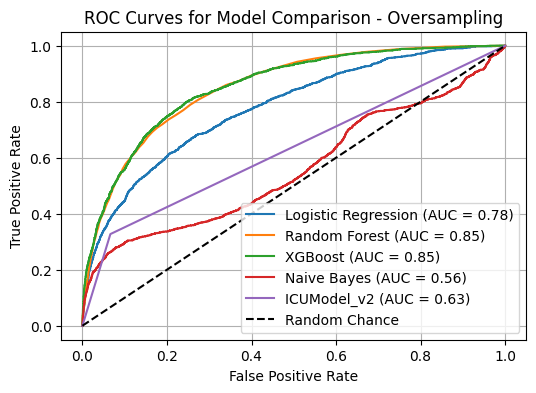

In [ ]:
plot_roc_curves(results, 'ROC Curves for Model Comparison - Oversampling')


# # RQ 2:

How does model performance compare to traditional clinical scoring systems (apache_4a_hospital_death_prob, apache_4a_icu_death_prob) for ICU mortality prediction?

### APACHE Report

=> extract relevent information from APACHE report for benchmark

In [ ]:
test_benchmark

80347    0.03
35956    0.02
44602     NaN
29096    0.11
56076    0.02
         ... 
34253    0.11
38734    0.04
26598    0.03
87468    0.04
60145    0.02
Name: benchmark, Length: 17668, dtype: float64

In [ ]:
test_benchmark = test_benchmark.fillna(0.5) # IMPUTE Nan to imply borderline assumption
train_benchmark_binary = train_benchmark.apply(lambda x: 1 if x > 0.5 else 0)
test_benchmark_binary = test_benchmark.apply(lambda x: 1 if x > 0.5 else 0)
test_benchmark_binary.value_counts()

benchmark
0    16905
1      763
Name: count, dtype: int64

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, test_benchmark_binary)
report_ = classification_report(y_test, test_benchmark_binary, output_dict=True)
conf_matrix = confusion_matrix(y_test, test_benchmark_binary)
fpr, tpr, _ = roc_curve(y_test, test_benchmark)
roc_auc = auc(fpr, tpr)
model_name = "Benchmark"
report = {str(int(float(k))) if k.replace('.', '', 1).isdigit() else k: v for k, v in report_.items()}

results[model_name] = {
    "Accuracy": accuracy,
    "Precision (Survived 0)": report["0"]["precision"],
    "Recall (Survived 0)": report["0"]["recall"],
    "F1-score (Survived 0)": report["0"]["f1-score"],
    "Precision (Death 1)": report["1"]["precision"],
    "Recall (Death 1)": report["1"]["recall"],
    "F1-score (Death 1)": report["1"]["f1-score"],
    "Confusion Matrix": conf_matrix.tolist(),
    "FPR": fpr.tolist(),  # Store FPR
    "TPR": tpr.tolist(),  # Store TPR
    "ROC AUC": roc_auc
    }
results1[model_name] = {
    "Accuracy": accuracy,
    "Precision (Survived 0)": report["0"]["precision"],
    "Recall (Survived 0)": report["0"]["recall"],
    "F1-score (Survived 0)": report["0"]["f1-score"],
    "Precision (Death 1)": report["1"]["precision"],
    "Recall (Death 1)": report["1"]["recall"],
    "F1-score (Death 1)": report["1"]["f1-score"],
    "Confusion Matrix": conf_matrix.tolist(),
    "FPR": fpr.tolist(),  # Store FPR
    "TPR": tpr.tolist(),  # Store TPR
    "ROC AUC": roc_auc
        }

Logistic Regression
Random Forest
XGBoost
Naive Bayes
ICUModel_v2
Benchmark


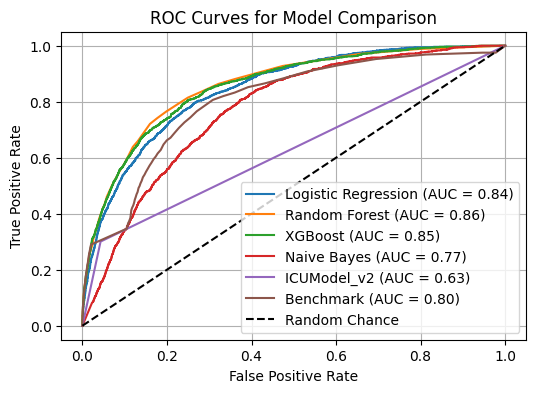

In [ ]:
plot_roc_curves(results1, 'ROC Curves for Model Comparison')

Logistic Regression
Random Forest
XGBoost
Naive Bayes
ICUModel_v2
Benchmark


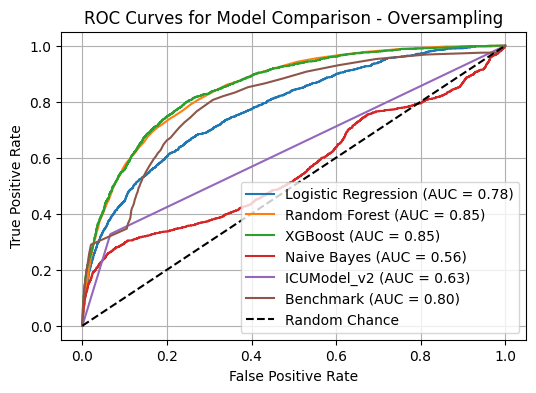

In [ ]:
plot_roc_curves(results, 'ROC Curves for Model Comparison - Oversampling')

In [ ]:
results1.pop('Naive Bayes')
results.pop('Naive Bayes')

Logistic Regression
Random Forest
XGBoost
ICUModel_v2
Benchmark
SimpleNet


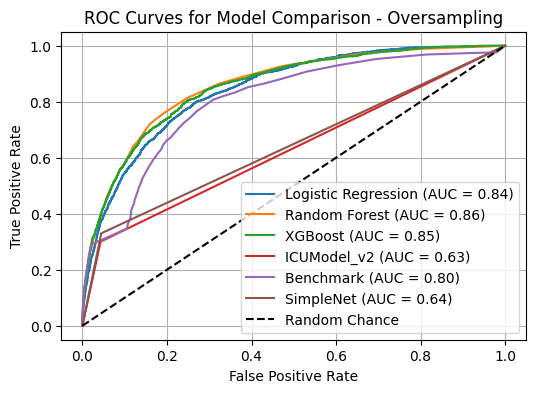

In [ ]:
plot_roc_curves(results1, 'ROC Curves for Model Comparison - Oversampling')

Logistic Regression
Random Forest
XGBoost
ICUModel_v2
Benchmark
SimpleNet


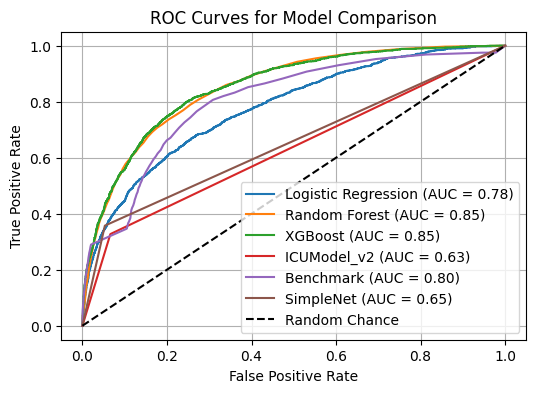

In [ ]:
plot_roc_curves(results, 'ROC Curves for Model Comparison')

In [ ]:
print_classification_report(results1)


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.97       0.78       0.87      16174
   Death (1)      0.24       0.74       0.36       1494

    accuracy                           0.78      17668
   macro avg      0.60       0.76       0.61      17668
weighted avg      0.91       0.78       0.82      17668

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.92       1.00       0.96      16174
   Death (1)      0.77       0.11       0.20       1494

    accuracy                           0.92      17668
   macro avg      0.84       0.56       0.58      17668
weighted avg      0.91       0.92       0.89      17668

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.93       0.98       0.96      16174
   Death (1)      0.59       0.25       0.35       1494

    accuracy                           0.92      17668
   macro avg      0.76       0.61       0.65      176

In [ ]:
print_classification_report(results)


Logistic Regression
              precision    recall    f1-score    support

Survived (0)      0.94       0.92       0.93      16174
   Death (1)      0.32       0.41       0.36       1494

    accuracy                           0.88      17668
   macro avg      0.63       0.67       0.65      17668
weighted avg      0.89       0.88       0.88      17668

Random Forest
              precision    recall    f1-score    support

Survived (0)      0.93       0.98       0.96      16174
   Death (1)      0.52       0.26       0.35       1494

    accuracy                           0.92      17668
   macro avg      0.73       0.62       0.65      17668
weighted avg      0.90       0.92       0.90      17668

XGBoost
              precision    recall    f1-score    support

Survived (0)      0.94       0.97       0.96      16174
   Death (1)      0.51       0.29       0.37       1494

    accuracy                           0.92      17668
   macro avg      0.72       0.63       0.66      176